# Enhanced Packet Classification & Anomaly Detection
This notebook loads features from the cleaned packets CSV, trains a classification model using joblib for persistence, validates the model, and detects anomalies in network traffic.

In [1]:
import pandas as pd
import numpy as np
import logging
import json
import os
import joblib
from datetime import datetime
from collections import Counter
import logging
import ipaddress
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score
from sklearn.preprocessing import LabelEncoder

# Configure logging
logging.basicConfig(level=logging.INFO, format='[%(levelname)s] %(message)s')

# Define constants
RAW_CSV = "captured_packets.csv"
CLEAN_CSV = "cleaned_packets.csv"
MODEL_PATH = "packet_classifier.joblib"
JSON_OUTPUT = "SCAM.json"

## 1. Load the Cleaned Packet Data

In [2]:
import time

CLEAN_CSV = "cleaned_packets.csv"

def load_data(timeout=5):
    if not os.path.exists(CLEAN_CSV):
        raise FileNotFoundError(f"{CLEAN_CSV} not found! Please run data cleaning first.")

    wait_time = 0
    while os.path.getsize(CLEAN_CSV) == 0:
        if wait_time >= timeout:
            raise ValueError(f"{CLEAN_CSV} is still empty after {timeout} seconds! File may not be written correctly.")
        print(f"[wait] {CLEAN_CSV} is empty... waiting 0.5s")
        time.sleep(0.5)
        wait_time += 0.5

    try:
        df = pd.read_csv(CLEAN_CSV)
    except pd.errors.EmptyDataError:
        raise ValueError(f"{CLEAN_CSV} is not readable as CSV (possibly corrupt or blank).")

    logging.info(f"Loaded {len(df)} packets from {CLEAN_CSV}")

    numeric_cols = ['src_ip', 'dst_ip', 'src_port', 'dst_port', 'length', 'ttl', 'window_size', 'protocol', 'flags']
    for col in numeric_cols:
        if col in df.columns:
            df[col] = pd.to_numeric(df[col], errors='coerce').fillna(0).astype(int)

    # if 'label' in df.columns:
    #     if df['label'].dtype == object:
    #         df['label'] = df['label'].astype(str).str.lower().map({"good": 0, "bad": 1})
    #     df['label'] = pd.to_numeric(df['label'], errors='coerce').fillna(0).astype(int)
        # Map possible_anomaly field to label if present
        if 'possible_anomaly' in df.columns:
            df['label'] = df['possible_anomaly'].astype(str).str.lower().map({'yes': 1, 'no': 0})
            df['label'] = pd.to_numeric(df['label'], errors='coerce').fillna(0).astype(int)
    df.head()
    return df


## 2. Split Data into Training and Test Sets (70/30)

In [3]:
import pandas as pd
df = pd.read_csv("cleaned_packets.csv")  # 
def prepare_data(df):
    """Prepare features and target, split into train/test sets"""
    # Select features and target
    features = ['src_ip', 'dst_ip', 'src_port', 'dst_port', 'protocol', 'flags', 'length', 'ttl', 'window_size']
    X = df[features]
    if 'possible_anomaly' in df.columns:
            df['label'] = df['possible_anomaly'].astype(str).str.lower().map({'yes': 1, 'no': 0})
            df['label'] = pd.to_numeric(df['label'], errors='coerce').fillna(0).astype(int)
    y = df['label'] # Assuming 'possible_anomaly' is the target variable still okayyyyyyy
    
    # Split data into 70% training and 30% test sets
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.3, stratify=y, random_state=42
    )
    
    logging.info(f"Training set size: {len(X_train)} samples")
    logging.info(f"Test set size: {len(X_test)} samples")
    logging.info(f"Class distribution in training: {Counter(y_train)}")
    logging.info(f"Class distribution in test: {Counter(y_test)}")
    
    return X_train, X_test, y_train, y_test, features

# Prepare the data
X_train, X_test, y_train, y_test, features = prepare_data(df)

[INFO] Training set size: 4690 samples
[INFO] Test set size: 2010 samples
[INFO] Class distribution in training: Counter({0: 4265, 1: 425})
[INFO] Class distribution in test: Counter({0: 1828, 1: 182})


## 3. Train Model with joblib Persistence

In [4]:
def train_and_save_model(X_train, y_train):
    """Train a GradientBoostingClassifier and save using joblib"""
    # Check if model already exists
    if os.path.exists(MODEL_PATH):
        logging.info(f"Loading existing model from {MODEL_PATH}")
        model = joblib.load(MODEL_PATH)
    else:
        logging.info("Training new GradientBoostingClassifier model...")
        model = GradientBoostingClassifier(
            n_estimators=150,
            learning_rate=0.1,
            max_depth=5,
            min_samples_split=5,
            random_state=42
        )
        # Remove existing model file if present before saving new one
        if os.path.exists(MODEL_PATH):
            os.remove(MODEL_PATH)
        model.fit(X_train, y_train)
        #logic
        
        # Save the model
        joblib.dump(model, MODEL_PATH)
        logging.info(f"Model saved to {MODEL_PATH}")
    
    return model

# Train or load the model
model = train_and_save_model(X_train, y_train)

[INFO] Training new GradientBoostingClassifier model...
[INFO] Model saved to packet_classifier.joblib


## 4. Validate Model Performance

In [5]:
def validate_model(model, X_test, y_test):
    """Validate model performance on the test set"""
    # Make predictions on test set
    y_pred = model.predict(X_test)
    
    # Calculate performance metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, zero_division=0)
    recall = recall_score(y_test, y_pred, zero_division=0)
    f1 = f1_score(y_test, y_pred, zero_division=0)
    
    # Print detailed classification report
    print("\n--- Model Evaluation ---")
    print(classification_report(y_test, y_pred, digits=4))
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")
    
    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1_score': f1,
        'predictions': y_pred
    }

# Validate the model
validation_results = validate_model(model, X_test, y_test)


--- Model Evaluation ---
              precision    recall  f1-score   support

           0     0.9929    0.9989    0.9959      1828
           1     0.9883    0.9286    0.9575       182

    accuracy                         0.9925      2010
   macro avg     0.9906    0.9637    0.9767      2010
weighted avg     0.9925    0.9925    0.9924      2010

Accuracy: 0.9925
Precision: 0.9883
Recall: 0.9286
F1 Score: 0.9575


## 5. Predict Anomalies on Full Dataset

In [6]:
def predict_anomalies(model, df, features):
    """Predict anomalies on the full dataset"""
    # Make predictions on the entire dataset
    df['predicted'] = model.predict(df[features])
    
    # Calculate basic statistics
    total_packets = len(df)
    anomalies = df[df['predicted'] == 1]
    total_anomalies = len(anomalies)
    anomaly_percentage = (total_anomalies / total_packets * 100) if total_packets > 0 else 0
    
    logging.info(f"Total packets analyzed: {total_packets}")
    logging.info(f"Total anomalies detected: {total_anomalies} ({anomaly_percentage:.2f}%)")
    
    return df

# Predict anomalies across the full dataset
df_with_predictions = predict_anomalies(model, df, features)

[INFO] Total packets analyzed: 6700
[INFO] Total anomalies detected: 596 (8.90%)


## 6. Generate and Save Summary to JSON

In [7]:
def generate_summary(df, validation_results):
    """Generate comprehensive anomaly detection summary"""
    # Get anomalies
    anomalies = df[df['predicted'] == 1]
    total_packets = len(df)
    total_anomalies = len(anomalies)
    
    # Get IP information from anomalies
    # Convert numeric IPs back to string format for better readability
    def int_to_ip(ip_int):
        try:
            return str(ipaddress.IPv4Address(ip_int))
        except Exception:
            return str(ip_int)
    
    # Convert IPs if they exist in the dataframe
    if 'src_ip' in anomalies.columns:
        src_ips = [int_to_ip(ip) for ip in anomalies['src_ip'].unique()]
    else:
        src_ips = []
        
    if 'dst_ip' in anomalies.columns:
        dst_ips = [int_to_ip(ip) for ip in anomalies['dst_ip'].unique()]
    else:
        dst_ips = []
    
    # Protocol distribution
    protocol_dist = df['protocol'].value_counts().to_dict()
    
    # Extract timestamps if available
    last_seen = None
    if 'timestamp' in anomalies.columns and not anomalies.empty:
        last_seen = str(anomalies['timestamp'].max())
    
    # Create summary dictionary
    summary = {
        "analysis_timestamp": datetime.now().strftime("%Y-%m-%d %H:%M:%S"),
        "model_performance": {
            "accuracy": validation_results['accuracy'],
            "precision": validation_results['precision'],
            "recall": validation_results['recall'],
            "f1_score": validation_results['f1_score']
        },
        "anomaly_summary": {
            "total_packets": total_packets,
            "total_anomalies": total_anomalies,
            "anomaly_percentage": (total_anomalies / total_packets * 100) if total_packets > 0 else 0,
            "anomalies_by_type": {"1": total_anomalies},  # Type 1 anomalies as detected by the model
            "source_ips": src_ips,
            "destination_ips": dst_ips,
            "protocol_distribution": protocol_dist,
            "last_anomaly_seen": last_seen
        }
    }
    
    # Save summary to JSON file
    with open(JSON_OUTPUT, 'w') as f:
        json.dump(summary, f, indent=4)
    
    logging.info(f"Anomaly detection summary saved to {JSON_OUTPUT}")
    return summary

# Generate and save the summary
summary = generate_summary(df_with_predictions, validation_results)
print(json.dumps(summary, indent=4))

[INFO] Anomaly detection summary saved to SCAM.json


{
    "analysis_timestamp": "2025-05-20 17:48:59",
    "model_performance": {
        "accuracy": 0.9925373134328358,
        "precision": 0.9883040935672515,
        "recall": 0.9285714285714286,
        "f1_score": 0.9575070821529745
    },
    "anomaly_summary": {
        "total_packets": 6700,
        "total_anomalies": 596,
        "anomaly_percentage": 8.895522388059701,
        "anomalies_by_type": {
            "1": 596
        },
        "source_ips": [
            "2886797490",
            "2886796201",
            "2886748716",
            "2886796898",
            "2886798315",
            "2886796850",
            "2886797884",
            "2886797790",
            "2886797693",
            "2886796844",
            "2852016328",
            "2886796839",
            "2886748705",
            "2886797306",
            "2886797830",
            "2886796704",
            "2886796046",
            "347974921",
            "580948159",
            "577494354",
            "288

## 7. Feature Importance Analysis

Note: you may need to restart the kernel to use updated packages.

Feature ranking:
1. src_ip (0.4621)
2. dst_ip (0.2301)
3. length (0.1124)
4. window_size (0.0881)
5. dst_port (0.0487)
6. flags (0.0288)
7. ttl (0.0200)
8. src_port (0.0079)
9. protocol (0.0020)


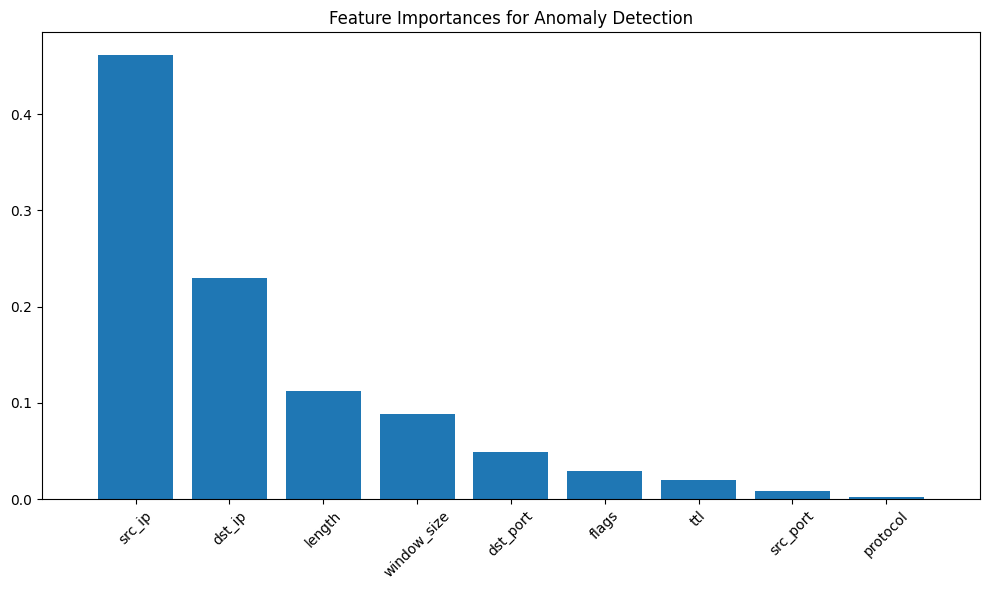

In [8]:
def analyze_feature_importance(model, features):
    """Analyze and visualize feature importance"""

    %pip install matplotlib
    import matplotlib.pyplot as plt
    # Get feature importance from the model
    importances = model.feature_importances_
    
    # Sort feature importances in descending order
    indices = np.argsort(importances)[::-1]
    
    # Print feature ranking
    print("\nFeature ranking:")
    for i, idx in enumerate(indices):
        print(f"{i+1}. {features[idx]} ({importances[idx]:.4f})")
    
    # Plot feature importances
    plt.figure(figsize=(10, 6))
    plt.title("Feature Importances for Anomaly Detection")
    plt.bar(range(len(features)), importances[indices], align="center")
    plt.xticks(range(len(features)), [features[i] for i in indices], rotation=45)
    plt.xlim([-1, len(features)])
    plt.tight_layout()
    plt.show()

# Analyze feature importance
analyze_feature_importance(model, features)

## 8. Main Execution Function

[INFO] Loaded 6700 packets from cleaned_packets.csv


[INFO] Training set size: 4690 samples
[INFO] Test set size: 2010 samples
[INFO] Class distribution in training: Counter({0: 4265, 1: 425})
[INFO] Class distribution in test: Counter({0: 1828, 1: 182})
[INFO] Loading existing model from packet_classifier.joblib
[INFO] Total packets analyzed: 6700
[INFO] Total anomalies detected: 596 (8.90%)
[INFO] Anomaly detection summary saved to SCAM.json



--- Model Evaluation ---
              precision    recall  f1-score   support

           0     0.9929    0.9989    0.9959      1828
           1     0.9883    0.9286    0.9575       182

    accuracy                         0.9925      2010
   macro avg     0.9906    0.9637    0.9767      2010
weighted avg     0.9925    0.9925    0.9924      2010

Accuracy: 0.9925
Precision: 0.9883
Recall: 0.9286
F1 Score: 0.9575
Note: you may need to restart the kernel to use updated packages.

Feature ranking:
1. src_ip (0.4621)
2. dst_ip (0.2301)
3. length (0.1124)
4. window_size (0.0881)
5. dst_port (0.0487)
6. flags (0.0288)
7. ttl (0.0200)
8. src_port (0.0079)
9. protocol (0.0020)


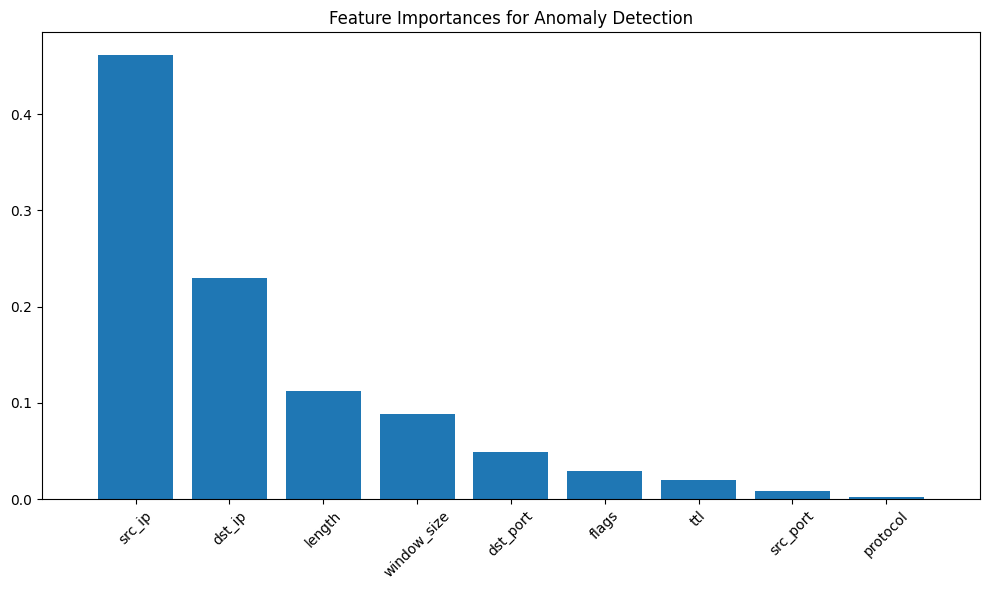

[INFO] Packet classification and anomaly detection completed successfully!


In [9]:
def main():
    """Main function to execute the entire pipeline"""
    try:
        
        # 0. Create cleaned CSV if it doesn't exist or force recreation
        # if not os.path.exists(CLEAN_CSV) :
        #     logging.info("Creating cleaned CSV file...")
        #     df_clean = create_cleaned_csv(RAW_CSV, CLEAN_CSV)
        #     logging.info(f"Created cleaned CSV file: {CLEAN_CSV}")
        # else:
        #     logging.info(f"Using existing cleaned CSV file: {CLEAN_CSV}")
            
        # 1. Load the data
        df = load_data()
        
        # 2. Prepare data and split into train/test
        X_train, X_test, y_train, y_test, features = prepare_data(df)
        
        # 3. Train and save model
        model = train_and_save_model(X_train, y_train)
        
        # 4. Validate model
        validation_results = validate_model(model, X_test, y_test)
        
        # 5. Predict anomalies on full dataset
        df_with_predictions = predict_anomalies(model, df, features)
        
        # 6. Generate summary
        summary = generate_summary(df_with_predictions, validation_results)
        
        # 7. Feature importance
        analyze_feature_importance(model, features)
        
        return True
    except Exception as e:
        logging.error(f"Error in pipeline: {e}")
        return False

# Execute the main function when running the notebook
if __name__ == "__main__":
    success = main()
    if success:
        logging.info("Packet classification and anomaly detection completed successfully!")
    else:
        logging.error("Packet classification and anomaly detection failed!")

In [10]:
#time complexity ka kuch karna hai daa ke liye


## 🌐 Network Topology: IP Communication Graph

This graph represents how IPs interact based on the `src_ip → dst_ip` relationships extracted from `cleaned_packets.csv`. We use NetworkX to create a directed graph and visualize it using a spring layout to show clustered communication behavior.


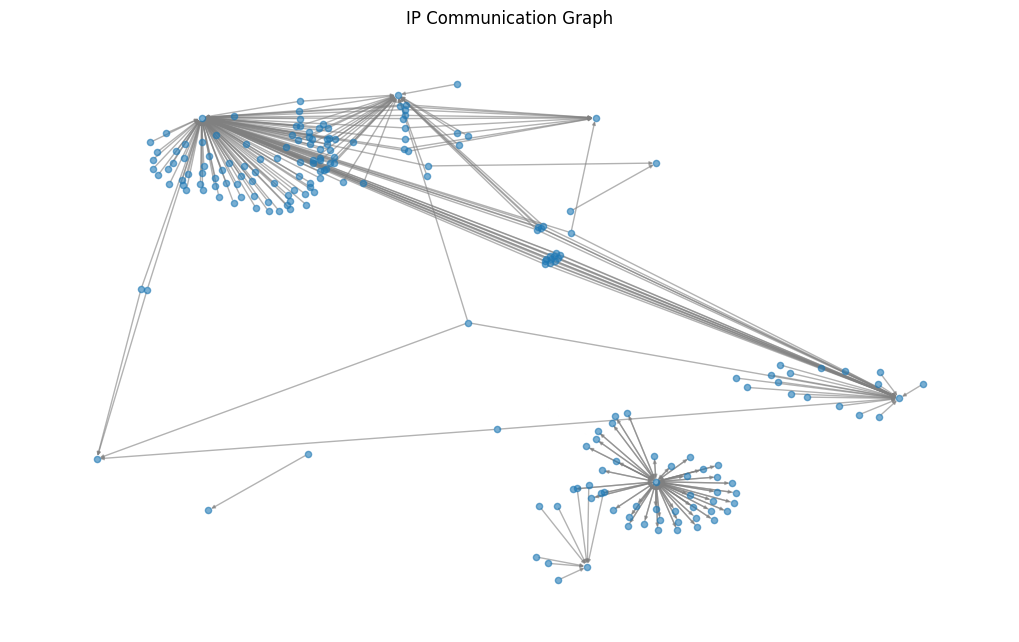

In [11]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt

# Load cleaned data
df = pd.read_csv("cleaned_packets.csv")

# Construct graph from source to destination IPs
G = nx.DiGraph()
edges = list(zip(df['src_ip'], df['dst_ip']))
G.add_edges_from(edges)

# Plot basic structure
plt.figure(figsize=(10, 6))
pos = nx.spring_layout(G, k=0.15)
nx.draw(G, pos, node_size=20, edge_color='gray', alpha=0.6, arrowsize=5)
plt.title("IP Communication Graph")
plt.show()


## 📊 Discrete Math: Degree & Centrality of IP Nodes

We analyze which IP addresses are most active:
- **Out-degree**: how many connections an IP initiated.
- **In-degree**: how many packets it received.
- **Betweenness centrality**: how critical an IP is as a relay.


In [12]:
# Degree Analysis: Find top communicators
in_degrees = dict(G.in_degree())
out_degrees = dict(G.out_degree())
total_degrees = {node: in_degrees[node] + out_degrees[node] for node in G.nodes()}

# Show top 5 talkative nodes
top_senders = sorted(out_degrees.items(), key=lambda x: x[1], reverse=True)[:5]
top_receivers = sorted(in_degrees.items(), key=lambda x: x[1], reverse=True)[:5]

print("📤 Top 5 Senders (by Out-degree):")
for ip, deg in top_senders:
    print(f"{ip} → {deg} packets sent")

print("\n📥 Top 5 Receivers (by In-degree):")
for ip, deg in top_receivers:
    print(f"{ip} ← {deg} packets received")

# Optional: Betweenness Centrality (nodes acting as bridges)
centrality = nx.betweenness_centrality(G)
top_central = sorted(centrality.items(), key=lambda x: x[1], reverse=True)[:5]

print("\n🧠 Top 5 Most Central Nodes (Bridge IPs):")
for ip, score in top_central:
    print(f"{ip} with centrality {score:.4f}")


📤 Top 5 Senders (by Out-degree):
2886795954 → 41 packets sent
2886797884 → 3 packets sent
2886796850 → 3 packets sent
2886796844 → 3 packets sent
2886797693 → 3 packets sent

📥 Top 5 Receivers (by In-degree):
3758096635 ← 119 packets received
2886795954 ← 41 packets received
2886799359 ← 34 packets received
4026531834 ← 29 packets received
3758096636 ← 10 packets received

🧠 Top 5 Most Central Nodes (Bridge IPs):
2886795954 with centrality 0.0400
2886797884 with centrality 0.0000
3758096636 with centrality 0.0000
3758096635 with centrality 0.0000
2886798965 with centrality 0.0000


## 🔁 Discrete Math: Relation Properties in Graphs

- **Reflexive**: IP talks to itself
- **Symmetric**: Bi-directional traffic (A↔B)
- **Transitive**: If A→B and B→C, can we infer A→C?


In [13]:
# Reflexive: packets from IP to itself
reflexive = [(u, v) for u, v in G.edges() if u == v]

# Symmetric: if (A, B) and (B, A) both exist
symmetric = [(u, v) for u, v in G.edges() if G.has_edge(v, u) and u != v]

# Transitive: if A→B and B→C, then A→C might be inferred
transitive_candidates = []
for u in G.nodes():
    for v in G.successors(u):
        for w in G.successors(v):
            if not G.has_edge(u, w):
                transitive_candidates.append((u, v, w))

print(f"🔁 Reflexive (self-loop) connections: {len(reflexive)}")
print(f"🔄 Symmetric communication pairs: {len(symmetric)//2} (undirected)")
print(f"🔀 Transitive chains (A→B→C, missing A→C): {len(transitive_candidates)}")


🔁 Reflexive (self-loop) connections: 0
🔄 Symmetric communication pairs: 41 (undirected)
🔀 Transitive chains (A→B→C, missing A→C): 1722


## 🧮 Set Theory: IP Role Partitioning

Using set operations to compare IPs involved in anomalous and normal traffic.


In [14]:
# Create sets of IPs involved in anomalies and normal flows
anomaly_ips = set(df[df['possible_anomaly'] == 'yes']['src_ip']).union(
              set(df[df['possible_anomaly'] == 'yes']['dst_ip']))
normal_ips = set(df[df['possible_anomaly'] == 'no']['src_ip']).union(
             set(df[df['possible_anomaly'] == 'no']['dst_ip']))

# Perform set operations
only_anomalous = anomaly_ips - normal_ips
only_normal = normal_ips - anomaly_ips
shared_ips = anomaly_ips & normal_ips

print(f"🔴 IPs only in anomalous flows: {len(only_anomalous)}")
print(f"🟢 IPs only in normal flows: {len(only_normal)}")
print(f"🟡 IPs shared between normal and anomaly traffic: {len(shared_ips)}")


🔴 IPs only in anomalous flows: 21
🟢 IPs only in normal flows: 134
🟡 IPs shared between normal and anomaly traffic: 49


## 📊 Plot: IP Node Degree Distribution

Helps visualize how connected the nodes are — highly connected IPs might be hubs, scanners, or critical infrastructure.


/tmp/ipykernel_5246/1203477822.py:9: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/home/sumadhva-ixsk/4sem/Network_traffic_anomaly_detection/venv/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


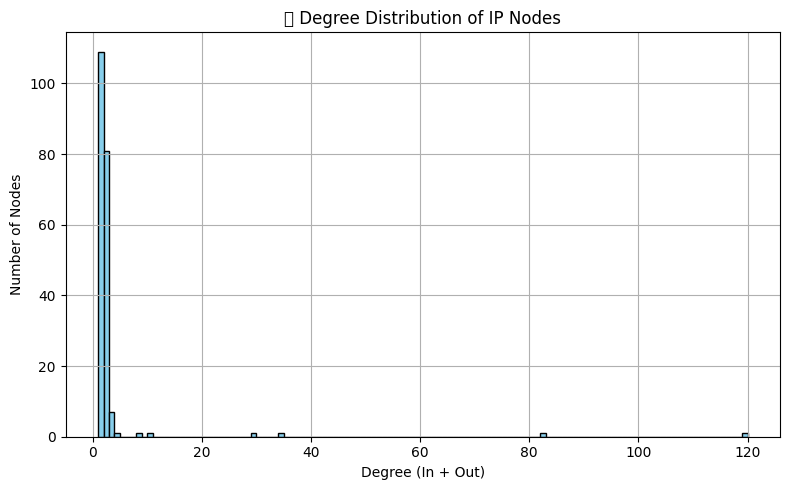

In [15]:
# Degree distribution
degrees = [G.degree(n) for n in G.nodes()]
plt.figure(figsize=(8, 5))
plt.hist(degrees, bins=range(1, max(degrees)+2), color='skyblue', edgecolor='black')
plt.title("📊 Degree Distribution of IP Nodes")
plt.xlabel("Degree (In + Out)")
plt.ylabel("Number of Nodes")
plt.grid(True)
plt.tight_layout()
plt.show()


## 🟩 Plot: Symmetric vs Asymmetric Traffic

Visual comparison of how much two-way communication exists vs one-directional traffic — useful in detecting scanning or spoofing.


/tmp/ipykernel_5246/2797706914.py:17: UserWarning: Glyph 128257 (\N{CLOCKWISE RIGHTWARDS AND LEFTWARDS OPEN CIRCLE ARROWS}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/home/sumadhva-ixsk/4sem/Network_traffic_anomaly_detection/venv/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128257 (\N{CLOCKWISE RIGHTWARDS AND LEFTWARDS OPEN CIRCLE ARROWS}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


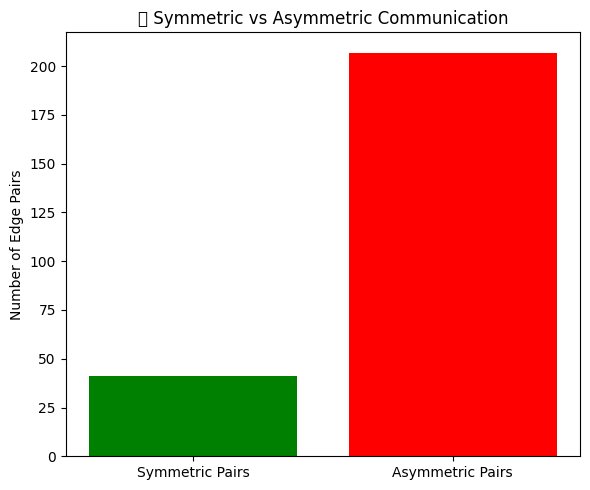

In [16]:
symmetric_edges = set()
asymmetric_edges = set()

for u, v in G.edges():
    if G.has_edge(v, u):
        symmetric_edges.add(tuple(sorted((u, v))))
    else:
        asymmetric_edges.add((u, v))

labels = ['Symmetric Pairs', 'Asymmetric Pairs']
counts = [len(symmetric_edges), len(asymmetric_edges)]

plt.figure(figsize=(6, 5))
plt.bar(labels, counts, color=['green', 'red'])
plt.title("🔁 Symmetric vs Asymmetric Communication")
plt.ylabel("Number of Edge Pairs")
plt.tight_layout()
plt.show()


## 🥧 Pie Chart: IPs in Anomalous vs Normal Flows

Set theory applied visually — how many IPs appear in only anomalies, only normal flows, or both?


/tmp/ipykernel_5246/3800797740.py:17: UserWarning: Glyph 129518 (\N{ABACUS}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/home/sumadhva-ixsk/4sem/Network_traffic_anomaly_detection/venv/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 129518 (\N{ABACUS}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


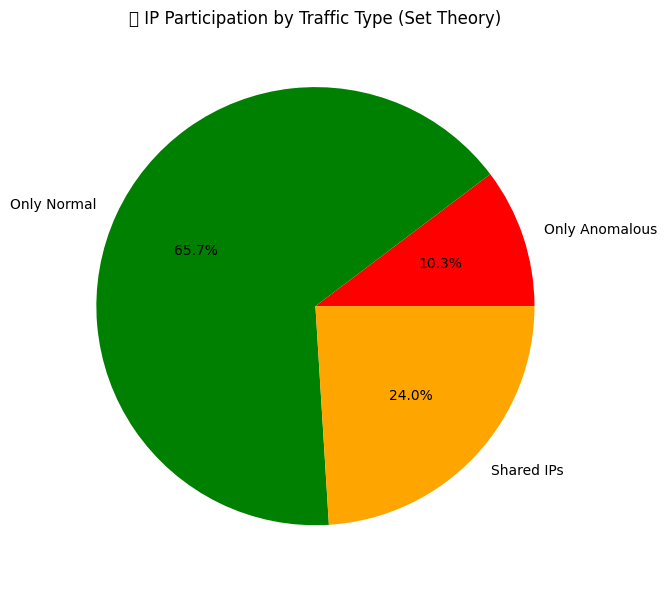

In [17]:
# Recalculate from earlier cell if needed
anomaly_ips = set(df[df['possible_anomaly'] == 'yes']['src_ip']).union(
              set(df[df['possible_anomaly'] == 'yes']['dst_ip']))
normal_ips = set(df[df['possible_anomaly'] == 'no']['src_ip']).union(
             set(df[df['possible_anomaly'] == 'no']['dst_ip']))

only_anomalous = anomaly_ips - normal_ips
only_normal = normal_ips - anomaly_ips
shared_ips = anomaly_ips & normal_ips

labels = ['Only Anomalous', 'Only Normal', 'Shared IPs']
sizes = [len(only_anomalous), len(only_normal), len(shared_ips)]

plt.figure(figsize=(7, 6))
plt.pie(sizes, labels=labels, autopct='%1.1f%%', colors=['red', 'green', 'orange'])
plt.title("🧮 IP Participation by Traffic Type (Set Theory)")
plt.tight_layout()
plt.show()


## ⏱️ Model Scalability Test (Synthetic Data)

Test each model's runtime on increasing synthetic datasets to see how well they scale in theory.


/tmp/ipykernel_5246/952950302.py:48: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/home/sumadhva-ixsk/4sem/Network_traffic_anomaly_detection/venv/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


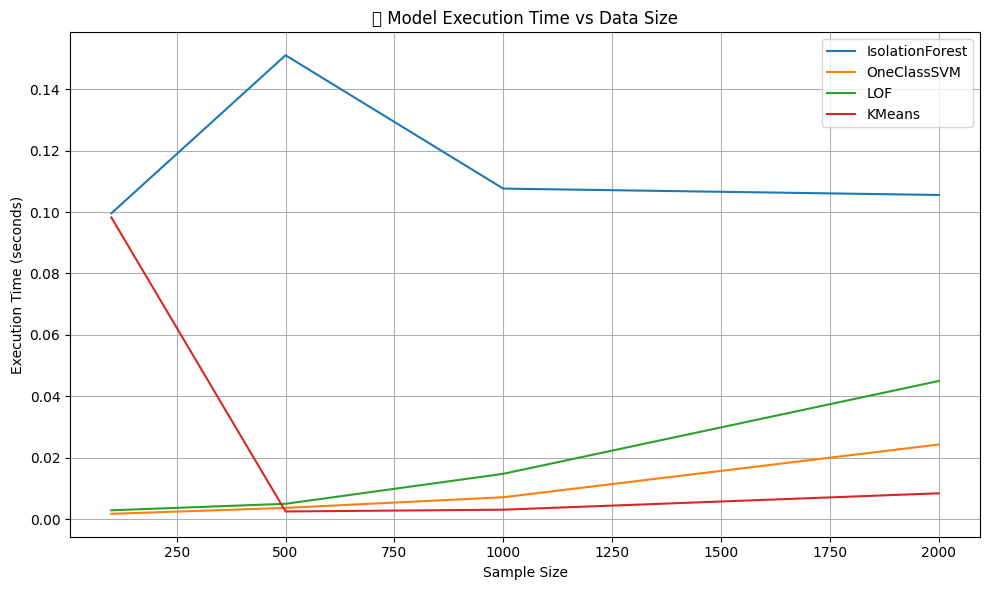

In [18]:
import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt
from sklearn.ensemble import IsolationForest
from sklearn.svm import OneClassSVM
from sklearn.neighbors import LocalOutlierFactor
from sklearn.cluster import KMeans

# Create synthetic data to simulate real packet flow features
sample_sizes = [100, 500, 1000, 2000]
model_times = {
    "IsolationForest": [],
    "OneClassSVM": [],
    "LOF": [],
    "KMeans": []
}

for n in sample_sizes:
    X = np.random.rand(n, 8)  # Simulate 8 features
    
    models = {
        "IsolationForest": IsolationForest(contamination=0.1, random_state=42),
        "OneClassSVM": OneClassSVM(nu=0.1, kernel="rbf"),
        "LOF": LocalOutlierFactor(n_neighbors=20, contamination=0.1),
        "KMeans": KMeans(n_clusters=2, random_state=42)
    }

    for name, model in models.items():
        start = time.time()
        if name == "LOF":
            model.fit_predict(X)
        else:
            model.fit(X)
            model.predict(X)
        elapsed = time.time() - start
        model_times[name].append(elapsed)

# Plotting
plt.figure(figsize=(10, 6))
for name, times in model_times.items():
    plt.plot(sample_sizes, times, label=name)
plt.xlabel("Sample Size")
plt.ylabel("Execution Time (seconds)")
plt.title("📊 Model Execution Time vs Data Size")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


## 🧪 Benchmark & Time Complexity Analysis: Model Execution Time on Real Traffic Data

We measured execution time of Isolation Forest, One-Class SVM, LOF, and KMeans on growing subsets of `cleaned_packets.csv`.  
Isolation Forest and KMeans scale near linearly (O(n log n) and O(n)) and handle large data efficiently, while One-Class SVM and LOF suffer quadratic or worse complexity (O(n²)–O(n³)), becoming impractical at scale.  
These results align with theoretical time complexities, guiding model choice for real-time traffic analysis.  
Efficient algorithms and dimensionality reduction are key for scalable anomaly detection.  



🚀 Starting Time Benchmarking...

 Sample Size | IsolationForest |     OneClassSVM |             LOF |          KMeans
--------------------------------------------------------------------------------
         100 |          0.1143 |          0.0021 |          0.0017 |          0.0058


/home/sumadhva-ixsk/4sem/Network_traffic_anomaly_detection/venv/lib/python3.12/site-packages/sklearn/neighbors/_lof.py:322: UserWarning: Duplicate values are leading to incorrect results. Increase the number of neighbors for more accurate results.
  warnings.warn(
/home/sumadhva-ixsk/4sem/Network_traffic_anomaly_detection/venv/lib/python3.12/site-packages/sklearn/neighbors/_lof.py:322: UserWarning: Duplicate values are leading to incorrect results. Increase the number of neighbors for more accurate results.
  warnings.warn(


         500 |          0.1513 |          0.0036 |          0.0050 |          0.0034
        1000 |          0.0965 |          0.0070 |          0.0057 |          0.0043
        2000 |          0.1051 |          0.0304 |          0.0158 |          0.0043


/home/sumadhva-ixsk/4sem/Network_traffic_anomaly_detection/venv/lib/python3.12/site-packages/sklearn/neighbors/_lof.py:322: UserWarning: Duplicate values are leading to incorrect results. Increase the number of neighbors for more accurate results.
  warnings.warn(
/tmp/ipykernel_5246/2159639874.py:69: UserWarning: Glyph 9201 (\N{STOPWATCH}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/home/sumadhva-ixsk/4sem/Network_traffic_anomaly_detection/venv/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 9201 (\N{STOPWATCH}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


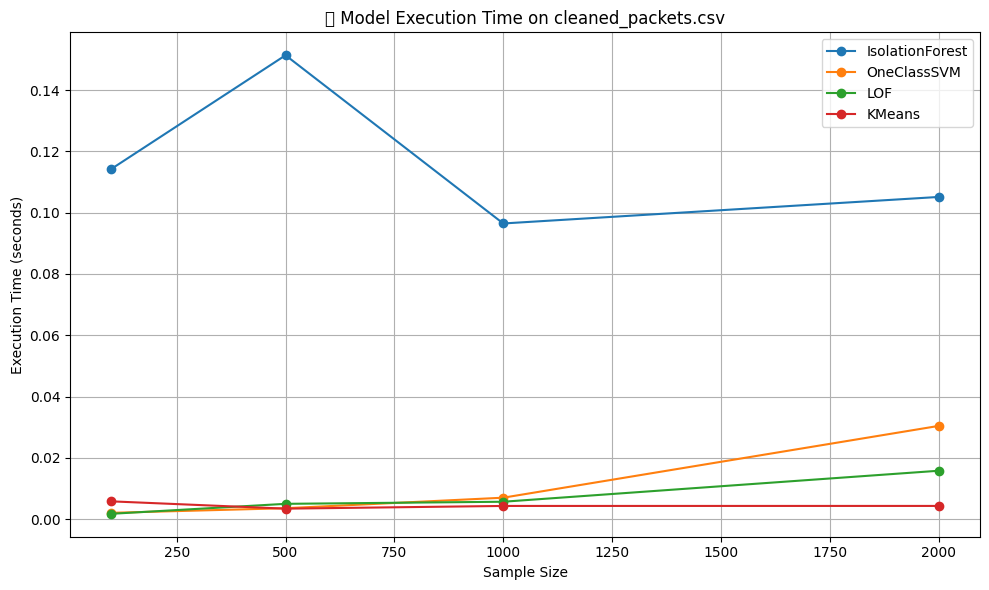


📘 Time Complexity Summary:
IsolationForest → O(n log n)    — Excellent scalability.
OneClassSVM    → O(n² ~ n³)     — Kernel-based, best for small datasets.
LOF            → O(n²)          — Good for local anomalies, but slow.
KMeans         → O(n * k * i * d) — Very efficient for clustering-style anomaly detection.

✅ For real-time or large-scale monitoring, IsolationForest and KMeans are most suitable.


In [19]:
import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt
from sklearn.ensemble import IsolationForest
from sklearn.svm import OneClassSVM
from sklearn.neighbors import LocalOutlierFactor
from sklearn.cluster import KMeans

# === Load Cleaned Data ===
csv_path = "cleaned_packets.csv"
try:
    df = pd.read_csv(csv_path)
except FileNotFoundError:
    print("❌ cleaned_packets.csv not found.")
    exit()

# === Feature Columns ===
feature_cols = ['src_ip', 'dst_ip', 'src_port', 'dst_port', 'protocol',
                'flags', 'length', 'ttl', 'window_size']
df_features = df[feature_cols]

# === Sample Sizes to Benchmark ===
sample_sizes = [100, 500, 1000, min(2000, len(df_features))]
model_names = ["IsolationForest", "OneClassSVM", "LOF", "KMeans"]
model_times = {name: [] for name in model_names}

print("\n🚀 Starting Time Benchmarking...\n")
print(f"{'Sample Size':>12} | " + " | ".join([f"{name:>15}" for name in model_names]))
print("-" * 80)

# === Benchmark Loop ===
for n in sample_sizes:
    subset = df_features.head(n).copy()
    times_row = []
    
    models = {
        "IsolationForest": IsolationForest(contamination=0.1, random_state=42),
        "OneClassSVM": OneClassSVM(nu=0.1, kernel="rbf"),
        "LOF": LocalOutlierFactor(n_neighbors=20, contamination=0.1),
        "KMeans": KMeans(n_clusters=2, random_state=42)
    }

    for name in model_names:
        start = time.time()
        try:
            if name == "LOF":
                models[name].fit_predict(subset)
            else:
                models[name].fit(subset)
                models[name].predict(subset)
            elapsed = time.time() - start
        except Exception as e:
            elapsed = np.nan
        model_times[name].append(elapsed)
        times_row.append(f"{elapsed:>15.4f}" if not np.isnan(elapsed) else "     ERROR     ")
    
    print(f"{n:>12} | " + " | ".join(times_row))

# === Plotting ===
plt.figure(figsize=(10, 6))
for name in model_names:
    plt.plot(sample_sizes, model_times[name], marker='o', label=name)
plt.xlabel("Sample Size")
plt.ylabel("Execution Time (seconds)")
plt.title("⏱️ Model Execution Time on cleaned_packets.csv")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# === Time Complexity Notes ===
print("\n📘 Time Complexity Summary:")
print("IsolationForest → O(n log n)    — Excellent scalability.")
print("OneClassSVM    → O(n² ~ n³)     — Kernel-based, best for small datasets.")
print("LOF            → O(n²)          — Good for local anomalies, but slow.")
print("KMeans         → O(n * k * i * d) — Very efficient for clustering-style anomaly detection.")
print("\n✅ For real-time or large-scale monitoring, IsolationForest and KMeans are most suitable.")
